In [2]:
using Pkg
Pkg.activate(".")

using JLD2, Plots, Lux, QuadGK, ComponentArrays, PhasorNetworks

  Activating project at `~/code/phasor_julia`


In [ ]:
using HypothesisTests

# Load the trained networks

In [3]:
result_dir = "parameters"

"parameters"

In [4]:
all_results = readdir(result_dir);

In [5]:
function ode_result(filename)
    pattern = r"^ode"
    return occursin(pattern, filename)
end

function pmlp_result(filename)
    pattern = r"^pmlp"
    return occursin(pattern, filename)
end

function mlp_result(filename)
    pattern = r"^mlp"
    return occursin(pattern, filename)
end

mlp_result (generic function with 1 method)

In [6]:
mlp_files = all_results[findall(mlp_result.(all_results))]
pmlp_files = all_results[findall(pmlp_result.(all_results))]
ode_files = all_results[findall(ode_result.(all_results))];

In [7]:
mlps = [load_object(joinpath(result_dir, f)) for f in mlp_files]
pmlps = [load_object(joinpath(result_dir, f)) for f in pmlp_files]
odes = [load_object(joinpath(result_dir, f)) for f in ode_files];

In [8]:
mlps[1]["auroc static"]

0.8327311530758456

In [9]:
auroc_mlps = [n["auroc static"] for n in mlps]
auroc_pmlps_static = [n["auroc static"] for n in pmlps]
auroc_pmlps_dynamic = [n["auroc dynamic"] for n in pmlps]
auroc_odes_static = [n["auroc static"] for n in odes]
auroc_odes_dynamic = [n["auroc dynamic"] for n in odes];

In [10]:
using StatsPlots

In [12]:
all_aurocs = stack((auroc_mlps, auroc_pmlps_static, auroc_pmlps_dynamic, auroc_odes_static, auroc_odes_dynamic), dims=2)

24×5 Matrix{Float64}:
 0.832731  0.82754   0.825927  0.862085  0.831241
 0.823481  0.829199  0.827248  0.859245  0.789082
 0.818331  0.828396  0.824636  0.857066  0.792409
 0.828331  0.826139  0.824381  0.857029  0.856581
 0.831908  0.826432  0.82316   0.852569  0.768787
 0.826935  0.827739  0.826047  0.857323  0.791318
 0.832255  0.829579  0.829477  0.857262  0.780969
 0.828287  0.825808  0.824176  0.851597  0.845324
 0.821783  0.827323  0.825811  0.856954  0.848179
 0.827611  0.826504  0.824016  0.856422  0.855604
 0.831342  0.827285  0.826903  0.856689  0.773355
 0.832283  0.823647  0.822167  0.853998  0.856787
 0.83152   0.826097  0.824332  0.85589   0.775358
 0.828881  0.828002  0.827374  0.85208   0.778739
 0.826276  0.82303   0.82349   0.855513  0.801374
 0.832316  0.82482   0.824548  0.851721  0.793122
 0.834118  0.827064  0.826109  0.857125  0.785355
 0.832599  0.825298  0.824316  0.849195  0.789621
 0.827689  0.827842  0.82438   0.855702  0.807199
 0.832668  0.828506  0.82694

In [42]:
using Statistics

In [43]:
mean(all_aurocs, dims=1)

1×5 Matrix{Float64}:
 0.829046  0.826901  0.825412  0.855387  0.804262

In [45]:
maximum(all_aurocs, dims=1)

1×5 Matrix{Float64}:
 0.834118  0.83005  0.829477  0.862085  0.857104

In [44]:
std(all_aurocs, dims=1)

1×5 Matrix{Float64}:
 0.00389671  0.00171998  0.00178736  0.00279142  0.0316595

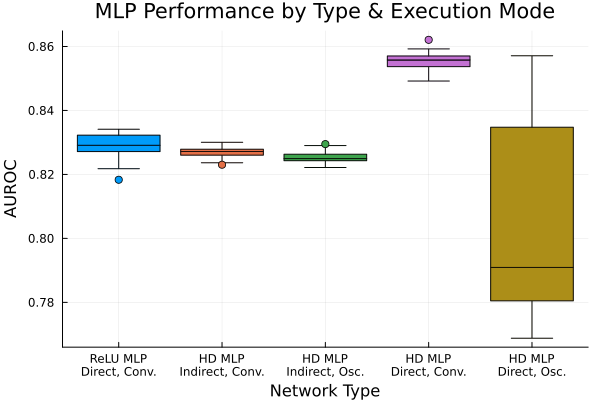

In [62]:
fig = boxplot(all_aurocs, label=missing)
xticks!([1.0, 2.0, 3.0, 4.0, 5.0], ["ReLU MLP\nDirect, Conv.", 
    "HD MLP\nIndirect, Conv.", 
    "HD MLP\nIndirect, Osc.", 
    "HD MLP\nDirect, Conv.", 
    "HD MLP\nDirect, Osc."])
    xlabel!("Network Type")
    ylabel!("AUROC")
title!("MLP Performance by Type & Execution Mode")

In [65]:
OneWayANOVATest(auroc_mlps, auroc_pmlps_static, auroc_pmlps_dynamic)

One-way analysis of variance (ANOVA) test
-----------------------------------------
Population details:
    parameter of interest:   Means
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-04

Details:
    number of observations: [24, 24, 24]
    F statistic:            11.2591
    degrees of freedom:     (2, 69)


In [67]:
MannWhitneyUTest(auroc_mlps, auroc_odes_static)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0266972

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-13

Details:
    number of observations in each group: [24, 24]
    Mann-Whitney-U statistic:             0.0
    rank sums:                            [300.0, 876.0]
    adjustment for ties:                  0.0


In [63]:
png(fig, "figures/nn_comparison.png")

"figures/nn_comparison.png"

In [40]:
MannWhitneyUTest(auroc_pmlps_static, auroc_odes_static)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0286217

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-13

Details:
    number of observations in each group: [24, 24]
    Mann-Whitney-U statistic:             0.0
    rank sums:                            [300.0, 876.0]
    adjustment for ties:                  0.0


In [14]:
conversion_error_pmlp = [auroc_pmlps_static .- auroc_pmlps_dynamic];
conversion_error_ode = [auroc_odes_static .- auroc_odes_dynamic];

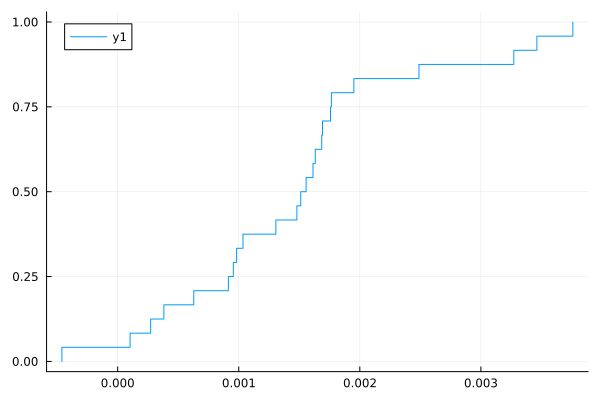

In [29]:
ecdfplot(conversion_error_pmlp[1])
#histogram!(conversion_error_ode, bins=21)

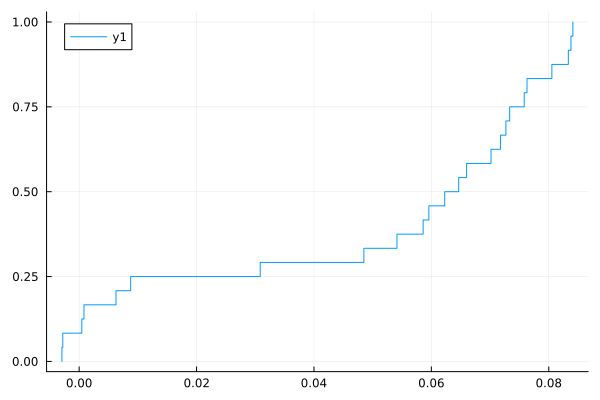

In [30]:
ecdfplot(conversion_error_ode[1])
#histogram!(conversion_error_ode, bins=21)

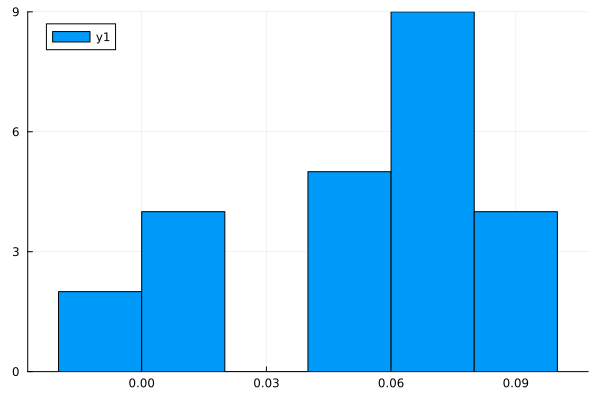

In [ ]:
histogram(conversion_error_ode)

In [37]:
MannWhitneyUTest(auroc_pmlps_static, auroc_pmlps_dynamic)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00221846

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0027

Details:
    number of observations in each group: [24, 24]
    Mann-Whitney-U statistic:             431.0
    rank sums:                            [731.0, 445.0]
    adjustment for ties:                  0.0


In [38]:
MannWhitneyUTest(auroc_mlps, auroc_pmlps_static)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00192446

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0052

Details:
    number of observations in each group: [24, 24]
    Mann-Whitney-U statistic:             422.0
    rank sums:                            [722.0, 454.0]
    adjustment for ties:                  0.0
